In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from pyclustering.cluster.clarans import clarans
import numpy as np
import spacy
from sklearn.pipeline import make_pipeline
from pyclustering.utils import draw_clusters
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
import seaborn as sns

nlp = spacy.load("en_core_web_sm")
df = pd.read_csv("airline.csv", encoding="latin-1")

# Drop unnecessary columns
df = df[['text', 'airline_sentiment']]

print(df.head())

def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

# Apply the preprocessing function to the 'text' column
df['processed_text'] = df['text'].apply(preprocess_text)






                                                text airline_sentiment
0                @VirginAmerica What @dhepburn said.           neutral
1  @VirginAmerica plus you've added commercials t...          positive
2  @VirginAmerica I didn't today... Must mean I n...           neutral
3  @VirginAmerica it's really aggressive to blast...          negative
4  @VirginAmerica and it's a really big bad thing...          negative


In [2]:
print("after the prepocessing")
print(df.head())

after the prepocessing
                                                text airline_sentiment  \
0                @VirginAmerica What @dhepburn said.           neutral   
1  @VirginAmerica plus you've added commercials t...          positive   
2  @VirginAmerica I didn't today... Must mean I n...           neutral   
3  @VirginAmerica it's really aggressive to blast...          negative   
4  @VirginAmerica and it's a really big bad thing...          negative   

                                      processed_text  
0                                                say  
1               plus add commercial experience tacky  
2                               today mean need trip  
3  aggressive blast obnoxious entertainment guest...  
4                                      big bad thing  


# Training the K-means model on the entire dataset

In [3]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', use_idf=True)
X = vectorizer.fit_transform(df['processed_text'])

# Dimensionality Reduction
n_components = 5
svd = TruncatedSVD(n_components)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(X)

# KMeans Clustering
true_k = 3  
minibatch = True
if minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1, init_size=1000, batch_size=1000)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
km.fit(X)
# Cluster Analysis
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
print(order_centroids)

for i in range(true_k):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])




[[3415  937 1844 ... 3144 2038 2595]
 [1473  567 1484 ... 3586  694   25]
 [3822 1473 3415 ... 1594  402  817]]
Cluster 0:
 service
 customer
 hour
 hold
 flight
 wait
 help
 time
 bad
 delay
Cluster 1:
 flight
 cancel
 flightle
 delay
 hour
 help
 time
 late
 hold
 need
Cluster 2:
 thank
 flight
 service
 help
 customer
 great
 hour
 time
 good
 send


In [4]:
# Evaluation Metrics
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df['airline_sentiment'], km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(df['airline_sentiment'], km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(df['airline_sentiment'], km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(df['airline_sentiment'], km.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, km.labels_, sample_size=1000))

Homogeneity: 0.084
Completeness: 0.087
V-measure: 0.086
Adjusted Rand-Index: 0.083
Silhouette Coefficient: 0.436


The interpretation of the results is influenced by the characteristics of the dataset, as the outcomes are affected by a variety of features.

### The plot


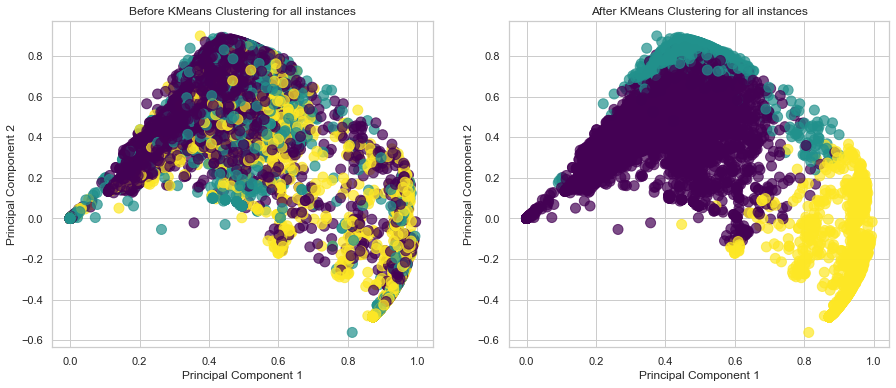

In [5]:
# Set seaborn style for improved aesthetics
sns.set(style="whitegrid")
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Before KMeans Clustering
axes[0].scatter(X[:, 0], X[:, 1], c=df['airline_sentiment'].map(sentiment_mapping), cmap="viridis", alpha=0.7, s=100)
axes[0].set_title('Before KMeans Clustering for all instances')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')

# After KMeans Clustering
axes[1].scatter(X[:, 0], X[:, 1], c=km.labels_, cmap="viridis", alpha=0.7, s=100)
axes[1].set_title('After KMeans Clustering for all instances')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')

# Display the plots
plt.show()


# CLARANS AND KMEANS FOR 1000 LINES

We limited the application of CLARANS to 1000 lines due to its time-consuming nature for processing all lines. Additionally, we trained the K-means model on the same subset for comparison

In [6]:
# CLARANS Clustering after Dimensionality Reduction 
#tring
from pyclustering.cluster.clarans import clarans
data=X[:1000]
clarans_instance = clarans(data=data, number_clusters=3, numlocal=2, maxneighbor=5)
clarans_instance.process()
clusters = clarans_instance.get_clusters()






In [7]:

# Metrics after CLARANS
clarans_labels = np.full(len(df), fill_value=-1)  # Initialize labels with -1
for cluster_idx, cluster in enumerate(clusters):
    clarans_labels[cluster] = cluster_idx

print("\nMetrics after CLARANS:")
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df['airline_sentiment'][:1000], clarans_labels[:1000]))
print("Completeness: %0.3f" % metrics.completeness_score(df['airline_sentiment'][:1000], clarans_labels[:1000]))
print("V-measure: %0.3f" % metrics.v_measure_score(df['airline_sentiment'][:1000], clarans_labels[:1000]))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(df['airline_sentiment'][:1000], clarans_labels[:1000]))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X[:1000], clarans_labels[:1000], sample_size=1000))



Metrics after CLARANS:
Homogeneity: 0.031
Completeness: 0.029
V-measure: 0.030
Adjusted Rand-Index: 0.038
Silhouette Coefficient: 0.347


 Kmeans for 1000 lines

In [8]:
#We applied K-means specifically to 1000 lines for the purpose of comparison with CLARANS.
d=X[:1000]
# KMeans Clustering
true_k = 3  # Update the number of clusters as needed
minibatch = True
if minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1, init_size=1000, batch_size=1000)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
km.fit(d)

# Cluster Analysis
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()


for i in range(true_k):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])




Cluster 0:
 hour
 hold
 wait
 flight
 help
 service
 customer
 time
 delay
 plane
Cluster 1:
 service
 customer
 flight
 bad
 thank
 help
 fly
 time
 airline
 wait
Cluster 2:
 flight
 cancel
 thank
 flightle
 delay
 help
 time
 late
 tomorrow
 need


In [11]:
print("\nMetrics after KMEANS MINI BATCH:")
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df['airline_sentiment'][:1000], km.labels_[:1000]))
print("Completeness: %0.3f" % metrics.completeness_score(df['airline_sentiment'][:1000], km.labels_[:1000]))
print("V-measure: %0.3f" % metrics.v_measure_score(df['airline_sentiment'][:1000], km.labels_[:1000]))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(df['airline_sentiment'][:1000], km.labels_[:1000]))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X[:1000], km.labels_[:1000], sample_size=1000))



Metrics after KMEANS MINI BATCH:
Homogeneity: 0.023
Completeness: 0.021
V-measure: 0.022
Adjusted Rand-Index: 0.009
Silhouette Coefficient: 0.352


## The comparaison :

### The plot of Kmeans Minibatch:

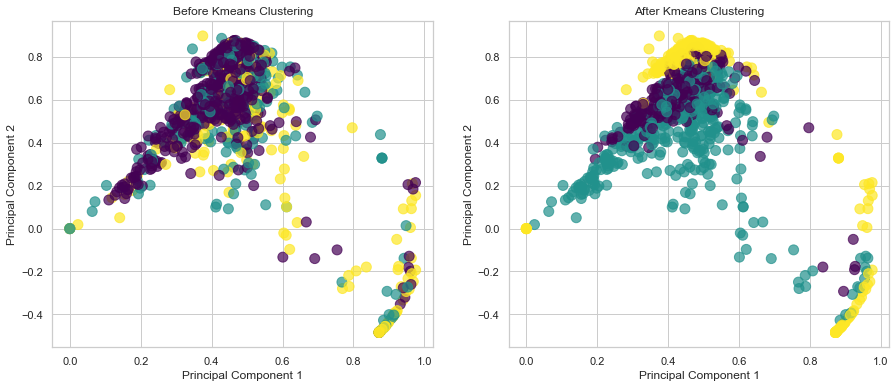

In [9]:
# Set seaborn style for improved aesthetics
sns.set(style="whitegrid")

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
# Before CLARANS Clustering
axes[0].scatter(X[:1000, 0], X[:1000, 1], c=df['airline_sentiment'][:1000].map(sentiment_mapping), cmap="viridis", alpha=0.7, s=100)
axes[0].set_title('Before Kmeans Clustering')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')

# After CLARANS Clustering
axes[1].scatter(X[:1000, 0], X[:1000, 1], c=km.labels_[:1000], cmap="viridis", alpha=0.7, s=100)
axes[1].set_title('After Kmeans Clustering')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')

# Display the plots
plt.show()


### The plot of CLARANS

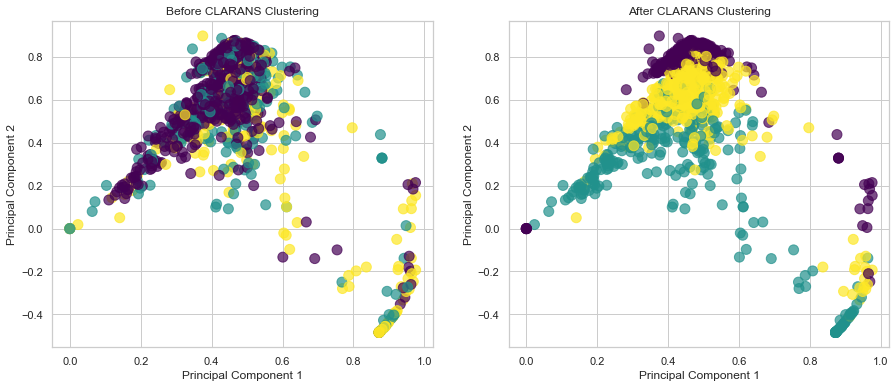

In [10]:
# Set seaborn style for improved aesthetics
sns.set(style="whitegrid")

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Before CLARANS Clustering
axes[0].scatter(X[:1000, 0], X[:1000, 1], c=df['airline_sentiment'][:1000].map(sentiment_mapping), cmap="viridis", alpha=0.7, s=100)
axes[0].set_title('Before CLARANS Clustering')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')

# After CLARANS Clustering
axes[1].scatter(X[:1000, 0], X[:1000, 1], c=clarans_labels[:1000], cmap="viridis", alpha=0.7, s=100)
axes[1].set_title('After CLARANS Clustering')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')

# Display the plots
plt.show()


# Comparison on a Smaller Dataset (1000 lines):

### KMeans Mini Batch:

Homogeneity: 0.023
Completeness: 0.021
V-measure: 0.022
ARI: 0.009
Silhouette Coefficient: 0.352
### CLARANS:

Homogeneity: 0.031
Completeness: 0.029
V-measure: 0.030
ARI: 0.038
Silhouette Coefficient: 0.347

#### Observation: 
CLARANS exhibits slightly better results on the smaller dataset, showing higher scores in homogeneity, completeness, V-measure, and ARI compared to KMeans Mini Batch. However, the differences are relatively marginal.

### Comparison on the Entire Dataset:

KMeans Mini Batch outperforms CLARANS on the entire dataset. This suggests that the scalability and efficiency of KMeans Mini Batch become more evident and advantageous when dealing with a larger amount of data.
### Dataset Feature Elimination Impact:

Observation: The results deviate from the course example, possibly due to the elimination of certain features. The nature and characteristics of the dataset, especially the presence or absence of specific features, significantly impact clustering algorithm performance. This underscores the importance of careful consideration when choosing clustering algorithms, as not all models may be suitable for a given dataset or scenario. The results highlight the sensitivity of clustering outcomes to the dataset's composition and the potential limitations of certain algorithms in specific contexts.

In summary, CLARANS demonstrates a slight advantage on a smaller dataset, while KMeans Mini Batch performs better on the entire dataset. The discrepancy from the course example highlights the importance of dataset-specific considerations.